In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments, RLIntro.RandomWalk

┌ Info: Precompiling ReinforcementLearning [158674fc-8238-5cab-b5ba-03dfc80d1318]
└ @ Base loading.jl:1273
┌ Info: Precompiling RLIntro [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1273
┌ Warning: Package RLIntro does not have StatsBase in its dependencies:
│ - If you have RLIntro checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RLIntro
└ Loading StatsBase into RLIntro from project dependency, future warnings for RLIntro are suppressed.


In [2]:
ACTIONS = collect(Iterators.flatten((-100:-1, 1:100)))
NS = 1002
NA = length(ACTIONS)

200

Here we define a group mapping preprocessor first.

The first and the last element will be grouped into another two separate group.

In [3]:
Base.@kwdef struct GroupMapping <: AbstractPreprocessor
    n::Int
    n_groups::Int
    n_per_group::Int=div(n, n_groups)
end

function (p::GroupMapping)(x::Int)
    if x == 1
        1
    elseif x == p.n
        p.n_groups + 2
    else
        div(x - 2, p.n_per_group) + 2
    end
end

And then define a hook to calculate the count of each state.

In [4]:
struct CountStates <: AbstractHook
    counts::Vector{Int}
    CountStates(n) = new(zeros(Int, n))
end

(f::CountStates)(::PreActStage, agent, env, obs_action) = f.counts[get_state(observe(env.env))] += 1

In [5]:
env = RandomWalkEnv(N=NS, actions=ACTIONS)

RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{Int64}(1, 1002, 1002), DiscreteSpace{Int64}(1, 200, 200))

In [6]:
observe(env)

Observation{Float64,Bool,Int64,NamedTuple{(),Tuple{}}}(0.0, false, 501, NamedTuple())

In [16]:
TRUE_STATE_VALUES = begin
    env = RandomWalkEnv(N=NS, actions=ACTIONS)
    agent = Agent(
        π=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularVApproximator(NS),
                method=:SRS,
                optimizer=Descent(0.01)
                ),
            f=TabularRandomPolicy(fill(1/NA, NS, NA))
            ),
        buffer=episode_RTSA_buffer()
    )
    run(agent, env, StopAfterEpisode(10^5))
    agent.π.learner.approximator.table
end

Progress:   0%|                                         |  ETA: 3:57:58
4m  TRAINING/EPISODE:  0
Progress:  13%|█████▏                                   |  ETA: 0:00:02
4m  TRAINING/EPISODE:  144
Progress:  35%|██████████████▎                          |  ETA: 0:00:01
4m  TRAINING/EPISODE:  406
Progress:  59%|████████████████████████▎                |  ETA: 0:00:00
4m  TRAINING/EPISODE:  714
Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:00
4m  TRAINING/EPISODE:  1012
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  1209


1002-element Array{Float64,1}:
  0.0               
 -0.9194659366885823
 -0.9124194704143702
 -0.9047036143767291
 -0.9048537549465595
 -0.8997009643199918
 -0.8907548820528697
 -0.8971182644803748
 -0.9043155039611362
 -0.9045325061059484
 -0.8951457286263845
 -0.8852027695236933
 -0.8910811689005118
  ⋮                 
  0.8943826155784217
  0.8885321601284034
  0.911184380577255 
  0.896757382458007 
  0.9139408172911353
  0.893853821373355 
  0.8959236856990294
  0.9036243373868817
  0.9181946899261548
  0.8966430747811418
  0.9142807930778952
  0.0               

In [11]:
using Plots

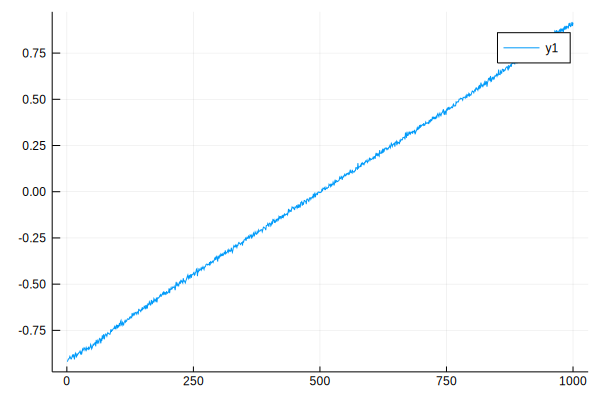

In [17]:
plot(TRUE_STATE_VALUES[2:end-1])

In [7]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

function (f::RecordRMS)(::PostActStage, agent, env, action_obs)
    action, obs = action_obs
    push!(f.rms, sqrt(mean((agent.π.learner.approximator.(env.preprocessor.(2:(NS-1))) - TRUE_STATE_VALUES[2:end-1]).^2)))
end

In [39]:
n_groups = 10
env = WrappedEnv(
    env=RandomWalkEnv(N=NS, actions=ACTIONS),
    preprocessor=GroupMapping(n=NS, n_groups=n_groups)
    )

WrappedEnv{RandomWalkEnv,GroupMapping}(RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{Int64}(1, 1002, 1002), DiscreteSpace{Int64}(1, 200, 200)), GroupMapping(1002, 10, 100))

In [42]:
agent = Agent(
    π=VBasedPolicy(
        learner=MonteCarloLearner(
            approximator=TabularVApproximator(n_groups+2),
            kind=EVERY_VISIT,  # this is very important!
            α=2e-5),
        f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
        ),
    buffer=episode_RTSA_buffer()
)

Agent{VBasedPolicy{MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling},TabularRandomPolicy},EpisodeTurnBuffer{(:reward, :terminal, :state, :action),Tuple{Float64,Bool,Int64,Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{Array{Float64,1},Array{Bool,1},Array{Int64,1},Array{Int64,1}}}},Symbol}(VBasedPolicy{MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling},TabularRandomPolicy}(MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling}(TabularVApproximator([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 1.0, 2.0e-5, CachedSampleAvg(Dict{Any,SampleAvg}())), TabularRandomPolicy([0.005 0.005 … 0.005 0.005; 0.005 0.005 … 0.005 0.005; … ; 0.005 0.005 … 0.005 0.005; 0.005 0.005 … 0.005 0.005])), NamedTuple{(:reward, :terminal, :state, :action),Tuple{Float64,Bool,Int

In [43]:
hook=CountStates(NS)
run(agent, env, StopAfterEpisode(10^5);hook=hook)

Progress:   0%|                                         |  ETA: 4:32:44
4m  TRAINING/EPISODE:  0
Progress:  37%|███████████████▎                         |  ETA: 0:00:00
4m  TRAINING/EPISODE:  437
Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:00
4m  TRAINING/EPISODE:  878
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  1161


CountStates([0, 1260, 1192, 1231, 1265, 1324, 1381, 1360, 1408, 1427  …  1460, 1320, 1366, 1333, 1285, 1288, 1216, 1245, 1236, 0])

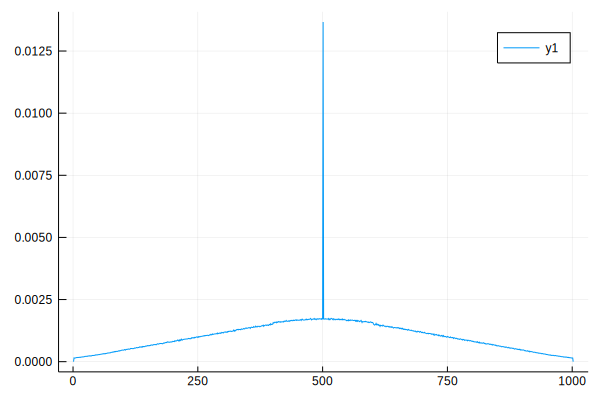

In [44]:
plot(hook.counts./sum(hook.counts))

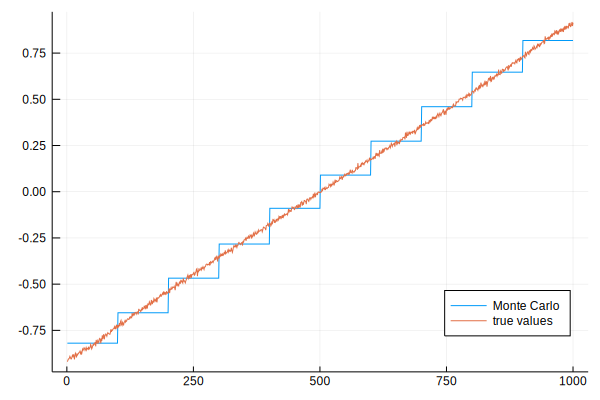

In [48]:
plot(agent.π.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="Monte Carlo")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [49]:
agent = Agent(
    π=VBasedPolicy(
        learner=TDLearner(
                approximator=TabularVApproximator(n_groups+2),
                method=:SRS,
                optimizer=Descent(2e-4)
                ),
        f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
        ),
    buffer=episode_RTSA_buffer()
)
run(agent, env, StopAfterEpisode(10^5))

Progress:  12%|████▉                                    |  ETA: 0:00:01
4m  TRAINING/EPISODE:  129
Progress:  41%|████████████████▊                        |  ETA: 0:00:00
4m  TRAINING/EPISODE:  458
Progress:  70%|████████████████████████████▉            |  ETA: 0:00:00
4m  TRAINING/EPISODE:  820
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  1173


EmptyHook()

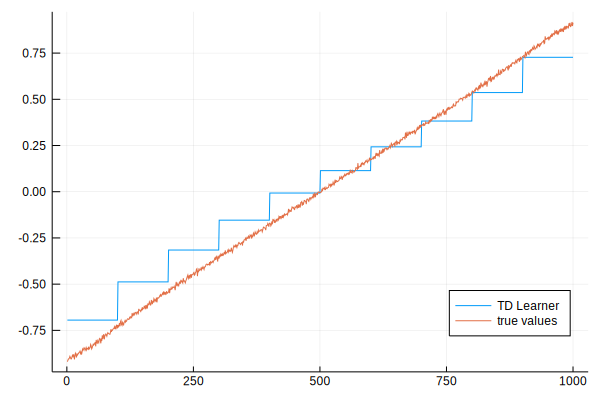

In [51]:
plot(agent.π.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="TD Learner")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [53]:
using StatsBase

Progress:  10%|████▏                                    |  ETA: 0:00:02
4m  TRAINING/EPISODE:  0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  0


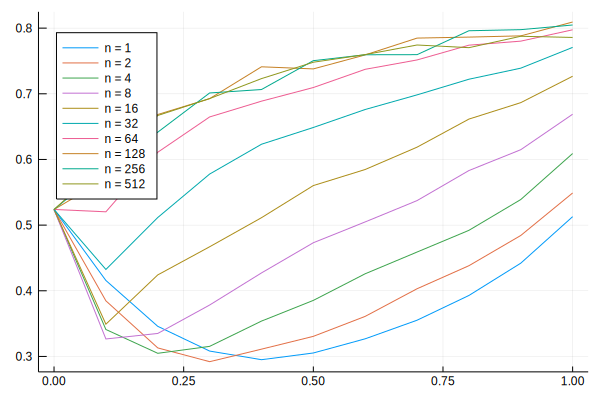

In [54]:
ngroups = 20
function run_once(n, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=GroupMapping(n=NS, n_groups=n_groups)
        )
    agent = Agent(
        π=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularVApproximator(n_groups+2),
                method=:SRS,
                optimizer=Descent(α),
                n=n
                ),
            f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
            ),
        buffer=episode_RTSA_buffer()
    )

    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(10); hook=hook)
    mean(hook.rms)
end

A = 0:0.1:1

p = plot(legend=:topleft)
for n in [2^i for i in 0:9]
    plot!(p, A, mean([run_once(n, α) for α in A] for _ in 1:100), label="n = $n")
end
p